# Find Best Traces to Evaluate the Results

In [1]:
import os
import glob
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dap.utils import obs_params, load_current
from dap import DAPcython

In [2]:
os.chdir('../')

In [3]:
from utils import calc_features_ramp, calc_features_step, find_spikes

## Load the Data 

#### Parameters

In [4]:
fname = 'dap_models_11_param_132.hdf'

df_steps = pd.read_hdf(fname, key='step_features')
df_ramps = pd.read_hdf(fname, key='ramp_features')
df_traces = pd.read_hdf(fname, key='param_traces')

In [5]:
df_traces.index.rename('id', inplace=True)
df_traces.reset_index(level=0, inplace=True)
df_traces.head(3)

,id,gbar_nap,gbar_leak,gbar_nat,gbar_kdr,gbar_hcn,nap_h_tau_max,nap_h_vs,nap_m_tau_max,nap_m_vs,kdr_n_tau_max,kdr_n_vs,distance_ramp,distance_step,distance_sum,step_traces,ramp_traces
0,1x17,12.692491,0.914429,152.774325,3.337843,0.052442,12.752524,-17.857580,13.416525,19.546395,23.300081,14.321779,1812.520024,2958.961226,4771.481250,"[-75.00008854684441, -74.74697834597083, -74.4...","[-74.98229133557048, -74.92470103308656, -74.8..."
1,1x10,12.351343,1.289652,147.333741,3.508594,0.054042,13.483098,-17.235360,14.311059,19.111308,22.572865,14.405826,1582.329303,2170.580447,3752.909750,"[-75.00003720765962, -74.80200795770736, -74.6...","[-75.01060135107491, -74.95714048394835, -74.9..."
2,1x8,11.867513,0.913729,152.808797,3.388063,0.055569,13.903332,-18.518087,15.227486,19.374805,22.986080,15.613157,1570.166581,2139.655230,3709.821812,"[-75.00069203863464, -74.78909511187177, -74.6...","[-74.99617438232215, -74.9767824266193, -74.93..."


#### Original Data

In [6]:
data_dir = '/home/alteska/Desktop/LFI_DAP/data/rawData/2015_08_26b.dat'

In [7]:
# calculate DAP
# load the input data
Ir, vr, tr, t_onr, t_offr, dtr = load_current(data_dir, protocol='rampIV', ramp_amp=3.1)
Is, vs, ts, t_ons, t_offs, dts = load_current(data_dir, protocol='IV', ramp_amp=1)

### Run Best Fit for Comparison

In [8]:
### Set up themodel
params, labels = obs_params(reduced_model=True)
dap = DAPcython(-75, params)
U = dap.simulate(dtr, tr, Ir)
U_step = dap.simulate(dts, ts, Is)

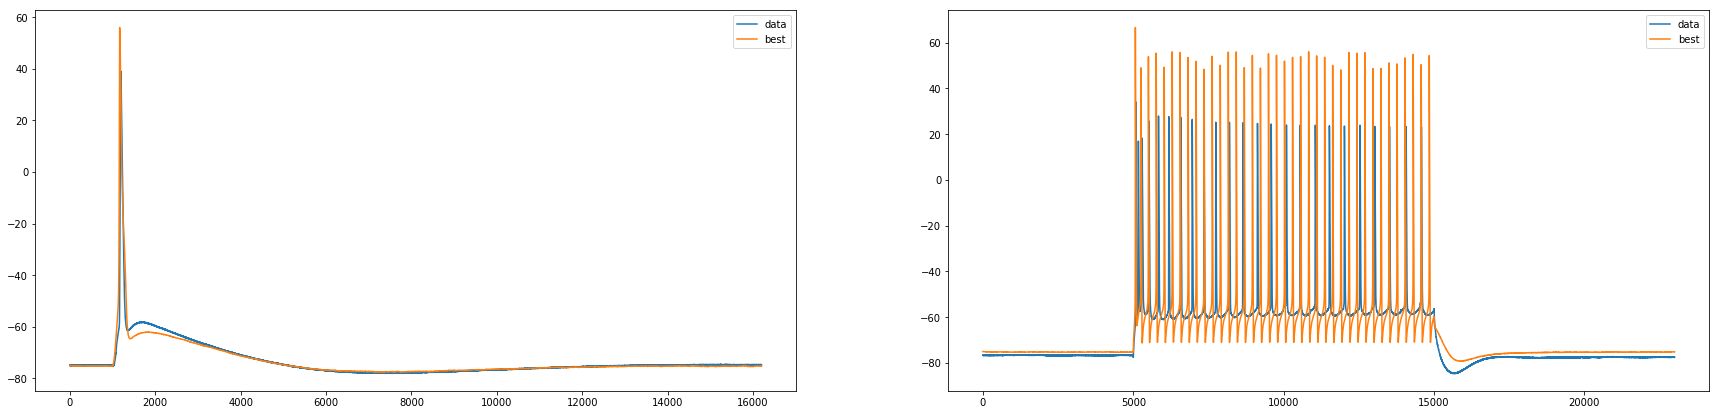

In [9]:
fig, ax  = plt.subplots(ncols=2, figsize=(30,7))
ax[0].plot(vr, label='data')
ax[0].plot(U, label='best')
ax[0].legend();

ax[1].plot(vs, label='data')
ax[1].plot(U_step, label='best');
ax[1].legend();

## Calculate The Features

In [10]:
data_feat_ramp = calc_features_ramp(vr, tr, dtr, t_onr, t_offr)
data_feat_ramp

array([-74.9345 , 113.997  ,   0.73   , -59.96875,  14.21575,  19.73   ,
        -0.75   ,   1.39   , -78.09375])

In [11]:
data_feat_step = calc_features_step(vs, ts, dts, t_ons, t_offs)
data_feat_step

array([-76.63358125, 0.06351057982730121, 48.0, 20.62173913043478,
       6.066798921122928, 24,
       array([254.6 , 258.4 , 264.6 , 275.95, 291.85, 309.  , 328.9 , 347.95,
       367.45, 387.1 , 409.75, 432.15, 456.4 , 479.25, 504.55, 527.35,
       552.55, 575.95, 600.95, 626.85, 651.45, 675.85, 703.5 , 728.9 ])],
      dtype=object)

## Create Comparison DF

#### Ramp Current

In [12]:
df_diff_ramps = np.abs(df_ramps.copy() - data_feat_ramp)
df_diff_ramps['sum'] = df_diff_ramps.sum(axis=1)
df_diff_ramps['sum'] = df_diff_ramps['sum']

df_diff_ramps.index.rename('id', inplace=True)
df_diff_ramps.reset_index(level=0, inplace=True)


#### Step Current

In [13]:
df_diff_steps = df_steps.dropna()
df_diff_steps.drop('spike_times_stim', axis=1, inplace=True)
df_diff_steps = np.abs(df_diff_steps - data_feat_step[:-1])

df_diff_steps.index.rename('id', inplace=True)
df_diff_steps.reset_index(level=0, inplace=True)
df_diff_steps['sum'] = df_diff_steps.drop('spike_count', axis=1).sum(axis=1)


/home/alteska/anaconda3/envs/dap2/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


### Pick The Best For Both Currents

In [14]:
n = 2
df_best_ramps = df_diff_ramps.sort_values('sum').head(n)
df_best_steps = df_diff_steps.sort_values('spike_count').head(n)

In [15]:
df_best_ramps

,id,rest_pot,AP_amp,AP_width,fAHP,DAP_amp,DAP_width,DAP_deflection,DAP_time,mAHP,sum
3,1x18,5.731794,10.70761,0.09,21.550587,26.889798,5.01,0.392583,0.66,3.833152,74.865523
15,1x19,2.616217,13.95481,0.08,19.004519,21.116981,14.70,0.503756,0.64,4.756205,77.372488


In [16]:
df_best_steps

,id,rest_pot,rest_pot_std,firing_rate,ISI_mean,ISI_std,spike_count,sum
13,1x19,5.339246,0.033989,2.0,0.961322,9.085442,1.0,17.420000
0,1x17,8.322677,0.033071,20.0,6.167194,6.255166,10.0,40.778108


## Merge With DFTraces to Get the best Traces and Parameters

In [17]:
names=['id','gbar_nap','gbar_leak','gbar_nat','gbar_kdr','gbar_hcn','ramp_traces', 'step_traces']

In [18]:
df_best_ramp_tr = pd.merge(df_traces, df_best_ramps)[names]
df_best_ramp_tr.head(3)

,id,gbar_nap,gbar_leak,gbar_nat,gbar_kdr,gbar_hcn,ramp_traces,step_traces
0,1x18,11.878740,0.961045,153.480377,3.129082,0.070680,"[-74.98379770068922, -74.95671435847864, -74.9...","[-74.99471610661163, -74.80377257943543, -74.6..."
1,1x19,12.480046,1.131259,143.657115,3.272230,0.049581,"[-74.9981522997508, -74.98906765378837, -74.96...","[-75.00907720427877, -74.89203944252036, -74.8..."


In [19]:
df_best_step_tr = pd.merge(df_traces, df_best_steps)[names]
df_best_step_tr.head(3)

,id,gbar_nap,gbar_leak,gbar_nat,gbar_kdr,gbar_hcn,ramp_traces,step_traces
0,1x17,12.692491,0.914429,152.774325,3.337843,0.052442,"[-74.98229133557048, -74.92470103308656, -74.8...","[-75.00008854684441, -74.74697834597083, -74.4..."
1,1x19,12.480046,1.131259,143.657115,3.272230,0.049581,"[-74.9981522997508, -74.98906765378837, -74.96...","[-75.00907720427877, -74.89203944252036, -74.8..."


## Visualize Best Results of Given Batch

### Ramp Current

In [20]:
traces_ramp = df_best_ramp_tr.ramp_traces
traces_step = df_best_ramp_tr.step_traces
ids = df_best_ramp_tr.id

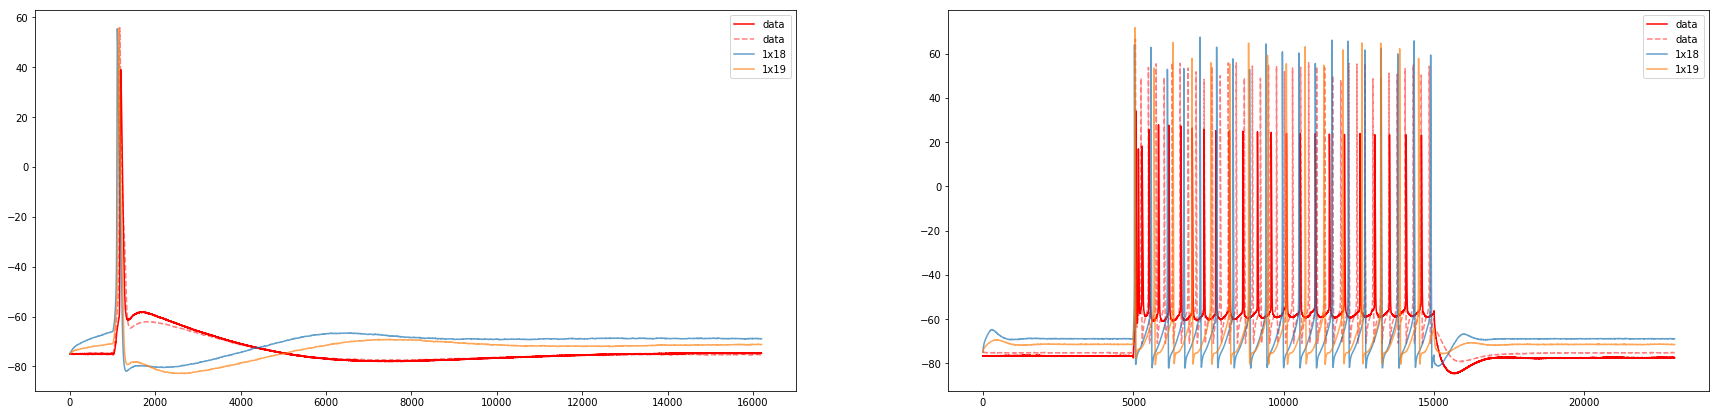

In [21]:
fig, ax = plt.subplots(ncols=2, figsize=(30, 7))

ax[0].plot(vr, c='r', label='data');
ax[0].plot(U, 'r--', alpha=0.5, label='data');

ax[1].plot(vs, c='r', label='data');
ax[1].plot(U_step, 'r--', alpha=0.5, label='data');

for i, tr in enumerate(traces_ramp): 
    n = ids[i]
    ax[0].plot(tr, alpha=0.7, label=n)

for i, tr in enumerate(traces_step): 
    n = ids[i]
    ax[1].plot(tr, alpha=0.7, label=n)
    
ax[0].legend()
ax[1].legend();



### Step Current

In [22]:
traces_ramp = df_best_step_tr.ramp_traces
traces_step = df_best_step_tr.step_traces
ids = df_best_step_tr.id

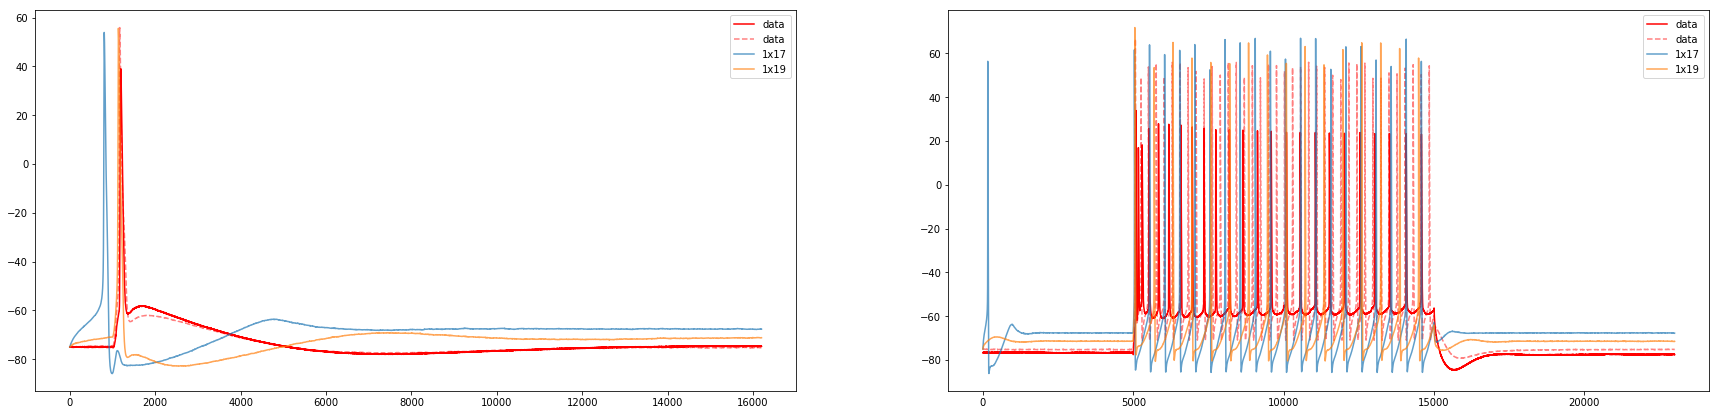

In [23]:
fig, ax = plt.subplots(ncols=2, figsize=(30, 7))

ax[0].plot(vr, c='r', label='data');
ax[0].plot(U, 'r--', alpha=0.5, label='data');

ax[1].plot(vs, c='r', label='data');
ax[1].plot(U_step, 'r--', alpha=0.5, label='data');

for i, tr in enumerate(traces_ramp): 
    n = ids[i]
    ax[0].plot(tr, alpha=0.7, label=n)

for i, tr in enumerate(traces_step): 
    n = ids[i]
    ax[1].plot(tr, alpha=0.7, label=n)
    
ax[0].legend()
ax[1].legend();
